## Import libraries

In [2]:
import numpy as np
import torch
import torchvision
import matplotlib.pyplot as plt
from time import time
from torchvision import datasets, transforms
from torch import nn,optim
from torch.utils.data import TensorDataset,DataLoader
from sklearn.metrics import f1_score,precision_score,recall_score,accuracy_score

## Download Dataset

In [3]:
training_set = datasets.MNIST('/content',train=True,download=True)
testing_set = datasets.MNIST('/content',transform=transforms.ToTensor(),train=False,download=True)

## Prepare the data

In [34]:
height = 28 # each image has height and width 28 pixels
image_size = 784 # size of each image

def invert_images(images):
    negative_images = np.empty(images.shape)
    
    for i in range(len(images)):
        image = images[i] # get the image
        num = (image > 127).sum()
        indices = np.random.choice(range(image_size),size=num,replace=False)
        negative_image = np.full(shape=image_size,fill_value=0,dtype=np.float32)
        negative_image[indices] = 1
        negative_image = negative_image.reshape(height,height)
        negative_images[i] = negative_image
    return negative_images
        
normalize = lambda image : image / 255 # function for bringing pixel values in range [0,1]

# function to prepare the dataset for a given digit
def prepare_data(dataset,digit):
    dataset_images = dataset.data.numpy() # convert the dataset into numpy array
    dataset_labels = dataset.targets.numpy() # convert the labels into numpy array
    
    indices = np.asarray(np.where(dataset_labels == digit)) # indices of occurrence of digit as label
    indices = indices.flatten()
    num_of_examples = len(indices) # total number of examples of this digit
    dataset_images_positive = dataset_images[indices] # images consisting of positive class
    # positive class has all labels as 1s
    dataset_labels_positive = np.full(shape=num_of_examples,fill_value=1,dtype=np.int64)
    dataset_images_negative = invert_images(dataset_images_positive) # images consisting of negative class
    # negative class has all labels as 0s
    dataset_labels_negative = np.full(shape=num_of_examples,fill_value=0,dtype=np.int64) 

    modified_dataset_images = np.concatenate((dataset_images_positive,dataset_images_negative))
    modified_dataset_labels = np.concatenate((dataset_labels_positive,dataset_labels_negative))
    modified_dataset_images = normalize(modified_dataset_images)
    tensor_x = torch.Tensor(modified_dataset_images)
    tensor_y = torch.from_numpy(modified_dataset_labels)
    new_dataset = TensorDataset(tensor_x,tensor_y)
    return new_dataset

train_digit_set = prepare_data(training_set,0) # fetch the training set for a digit
test_digit_set = prepare_data(testing_set,1) # fetch the test set for a digit
train_loader = DataLoader(train_digit_set,batch_size=64,shuffle=True)
test_loader = DataLoader(testing_set,batch_size=64,shuffle=True) # take original testing set of 10 digits

### Plotting some data

tensor([1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0,
        0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1,
        1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1])


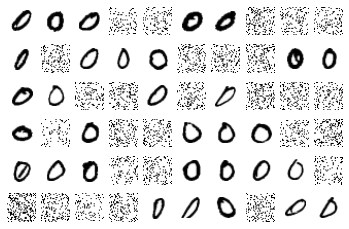

In [35]:
dataiter = iter(train_loader)
images,labels = dataiter.next()
print(labels)
figure = plt.figure()
num_of_images = 60
for index in range(1,num_of_images+1):
    plt.subplot(6,10,index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(),cmap='gray_r')

## Build the neural network

In [31]:
input_size = 784
hidden_sizes = [128,64]
output_size = 2

model = nn.Sequential(
    nn.Linear(input_size,hidden_sizes[0]),
    nn.ReLU(),
    nn.Linear(hidden_sizes[0],hidden_sizes[1]),
    nn.ReLU(),
    nn.Linear(hidden_sizes[1],output_size),
    nn.Softmax(dim=1)
)

criterion = nn.CrossEntropyLoss()
print(model)
optimizer = optim.SGD(model.parameters(),lr = 0.003,momentum=0.9)
time0 = time()
epochs = 15
for e in range(epochs):
    for images,labels in train_loader:
        images = images.view(images.shape[0],-1) # flatten the image
        optimizer.zero_grad() # training pass
        output = model(images)
        loss = criterion(output,labels)
        loss.backward() # backpropagation
        optimizer.step() # optimizes its weights here
        
print(f"\nTraining time in minutes = {(time()-time0)/60}")

Sequential(
  (0): Linear(in_features=784, out_features=128, bias=True)
  (1): ReLU()
  (2): Linear(in_features=128, out_features=64, bias=True)
  (3): ReLU()
  (4): Linear(in_features=64, out_features=2, bias=True)
  (5): Softmax(dim=1)
)

Training time in minutes = 0.12453002134958903


## Testing

In [33]:
correct_outputs = 0
total_outputs = 0
y_pred = [] # predicted labels
y_true = [] # true labels
for images,labels in test_loader:
    for i in range(len(labels)):
        img = images[i].view(1,784)
        true_label = labels.numpy()[i]
        if(true_label == 0):
            continue
        with torch.no_grad():
            probability_scores = model(img)
        probability_list = list(probability_scores.numpy()[0])
        pred_label = probability_list.index(max(probability_list))
#         if(pred_label == 0):
#             correct_outputs += 1
#         total_outputs += 1
        if(pred_label == 0):
            correct_outputs += 1
        total_outputs += 1
#         print(f"{true_label} {max_index}")
        
print(f"Correct Outputs: {correct_outputs} Total Outputs: {total_outputs}")
print(correct_outputs / total_outputs)
# print(f"\nModel Accuracy : {accuracy_score(y_true,y_pred)}")
# print(f"\nModel Precision : {precision_score(y_true,y_pred)}")
# print(f"\nModel Recall : {recall_score(y_true,y_pred)}")
# print(f"\nModel F1 score : {f1_score(y_true,y_pred)}")

Correct Outputs: 0 Total Outputs: 9020
0.0


## Save the Model

In [24]:
torch.save(model,'./mnist_model.pt')